<a href="https://colab.research.google.com/github/EmersonAlvaro/snakeID/blob/master/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pathlib
import os
import gc
import cv2 as cv
import random

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
# from tensorflow.keras.utils import np_utils
from sklearn import metrics
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from  tensorflow.keras.optimizers import Adam

num_class = 4
IMAGE_SIZE = 256
epoch = 70
loss_function = sparse_categorical_crossentropy
optmizer = Adam()
num_folds = 10

#container for metrics
acc_folds = []
f1_folds = []
prec_folds =[]
recall_folds = []

#Colab Path
train_data = pathlib.Path('/content/drive/My Drive/MozSnake/train/')
test_data = pathlib.Path('/content/drive/My Drive/MozSnake/test/')
pesos = pathlib.Path('/content/drive/My Drive/MozSnake/pesos/')

from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# **Read data from my drive**

In [10]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    file_names = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names += [os.path.join(label_directory, f)
                       for f in os.listdir(label_directory)]

    random.shuffle(file_names)
    random.shuffle(file_names)

    for f in file_names:
        # print(f)
        img = cv.imread(f)
        img = cv.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        dirname = os.path.split(os.path.dirname(f))[1]

        # print(dirname)

        images.append(img)
        labels.append(int(dirname))

    images, labels = np.asarray(images), np.asarray(labels)
    images = images.astype('float32') / 255.0

    return images, labels

imagens, labels = load_data(train_data)
print(imagens.shape)
print(labels.shape)

(1824, 256, 256, 3)
(1824,)


# **# Arquitetura do Xception**

(1641, 256, 256, 3)
(1641,)
Train on 1641 samples, validate on 183 samples
Epoch 1/70
1632/1641 [============================>.] - ETA: 0s - loss: 2.9959 - acc: 0.4069
Epoch 00001: acc improved from -inf to 0.40646, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [==============================] - 57s 35ms/sample - loss: 2.9937 - acc: 0.4065 - val_loss: 2.6844 - val_acc: 0.2514
Epoch 2/70
1632/1641 [============================>.] - ETA: 0s - loss: 2.2621 - acc: 0.5110
Epoch 00002: acc improved from 0.40646 to 0.51127, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [==============================] - 31s 19ms/sample - loss: 2.2616 - acc: 0.5113 - val_loss: 2.3798 - val_acc: 0.2459
Epoch 3/70
1632/1641 [============================>.] - ETA: 0s - loss: 1.8093 - acc: 0.5913
Epoch 00003: acc improved from 0.51127 to 0.58927, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [==============================

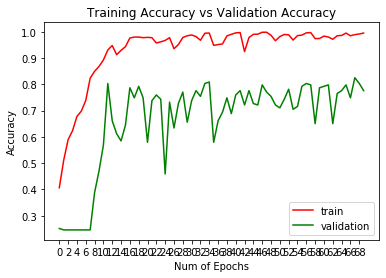

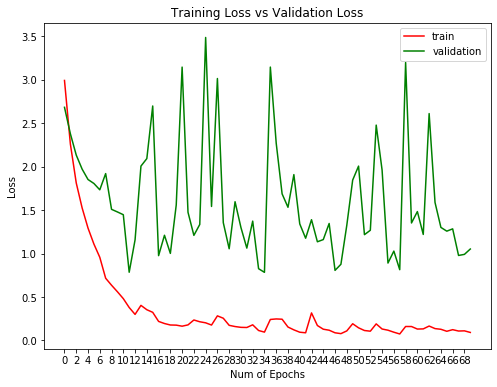

(1641, 256, 256, 3)
(1641,)
Load Model
Train on 1641 samples, validate on 183 samples
Epoch 1/70
1632/1641 [============================>.] - ETA: 0s - loss: 1.7002 - acc: 0.5135
Epoch 00001: acc improved from -inf to 0.51371, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [==============================] - 69s 42ms/sample - loss: 1.6996 - acc: 0.5137 - val_loss: 1180.9265 - val_acc: 0.2459
Epoch 2/70
1632/1641 [============================>.] - ETA: 0s - loss: 1.1485 - acc: 0.6072
Epoch 00002: acc improved from 0.51371 to 0.60756, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [==============================] - 33s 20ms/sample - loss: 1.1470 - acc: 0.6076 - val_loss: 21.9317 - val_acc: 0.2568
Epoch 3/70
1632/1641 [============================>.] - ETA: 0s - loss: 0.8464 - acc: 0.7298
Epoch 00003: acc improved from 0.60756 to 0.73004, saving model to /content/drive/My Drive/MozSnake/pesos/Xception.h5
1641/1641 [===============

In [0]:
def xception(num_class):
    stride = (2, 2);
    kernel_size = (3, 3)
    pool_size = (2, 2)
    Channel_axis = 3;

    def middle_flow(x):

        x_temp = x

        for i in range(8):
            x = tf.nn.relu(x)
            x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x)
            x = layers.BatchNormalization(axis=Channel_axis)(x)
            # x = layers.Dropout(0.2)(x)

            x = tf.nn.relu(x)
            x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x)
            x = layers.BatchNormalization(axis=Channel_axis)(x)
            # x = layers.Dropout(0.2)(x)

            x = tf.nn.relu(x)
            x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x)
            x = layers.BatchNormalization(axis=Channel_axis)(x)
            # x = layers.Dropout(0.2)(x)

            x = layers.add([x, x_temp])
            x_temp = x

        return x

    def exit_flow(x):

        x_temp = x

        x = tf.nn.relu(x)
        x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same',
                                   kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)
        # x = layers.Dropout(0.5)(x)

        x = tf.nn.relu(x)
        x = layers.SeparableConv2D(filters=1024, kernel_size=(3, 3), padding='same',
                                   kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)
        # x = layers.Dropout(0.5)(x)

        x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x_shortcut = layers.Conv2D(1024, kernel_size=(1, 1), strides=(2, 2), padding='same',
                                   kernel_regularizer=regularizers.l2(0.001))(x_temp)
        # x = layers.Dropout(0.5)(x)

        x = layers.add([x, x_shortcut])

        x = layers.SeparableConv2D(filters=1536, kernel_size=(3, 3), padding='same',
                                   kernel_regularizer=regularizers.l2(0.001))(x)
        x = tf.nn.relu(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)

        x = layers.SeparableConv2D(filters=2048, kernel_size=(3, 3), padding='same',
                                   kernel_regularizer=regularizers.l2(0.001))(x)
        x = tf.nn.relu(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)

        x = layers.GlobalAveragePooling2D()(x)

        output = layers.Dense(num_class, activation=tf.nn.softmax)(x)

        return output

    def entry_flow(img_input):

        x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same',
                          kernel_regularizer=regularizers.l2(0.001))(img_input)
        x = tf.nn.relu(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)

        x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = tf.nn.relu(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)

        x_temp = x

        for filter in [128, 256, 728]:
            if filter != 128:
                x = tf.nn.relu(x)
            x = layers.SeparableConv2D(filter, kernel_size=(3, 3), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x)
            x = layers.BatchNormalization(axis=Channel_axis)(x)
            # x = layers.Dropout(0.5)(x)

            x = tf.nn.relu(x)
            x = layers.SeparableConv2D(filter, kernel_size=(3, 3), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x)
            x = layers.BatchNormalization(axis=Channel_axis)(x)
            # x = layers.Dropout(0.5)(x)

            x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

            x_shortcut = layers.Conv2D(filter, kernel_size=(1, 1), strides=(2, 2), padding='same',
                                       kernel_regularizer=regularizers.l2(0.001))(x_temp)
            # x = layers.Dropout(0.5)(x)

            x = layers.add([x, x_shortcut])
            x_temp = x

        return x

    img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = entry_flow(img_input)
    x = middle_flow(x)
    output = exit_flow(x)

    model = models.Model(inputs=img_input, outputs=output, name='Xception')

    return model 

# xception = xception(num_class)
# print(xception.summary())

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=29)
indice = 0
for train, test in kf.split(imagens, labels):
    imgs_train, imgs_val = imagens[train], imagens[test]
    labs_train, labs_val = labels[train], labels[test]

    # labs_train = tf.keras.utils.to_categorical(labs_train, num_class)
    # labs_test = tf.keras.utils.to_categorical(labs_test, num_class)

    print(imgs_train.shape)
    print(labs_train.shape)

    model = xception(num_class)

    checkpoint = ModelCheckpoint(str(pesos) + "/Xception" +  ".h5",
                                 monitor='acc', verbose=1,
                                 save_best_only=True, mode='auto')
    if indice>0:
        model.load_weights(str(pesos) + "/Xception" + ".h5")
        print("Load Model")

    model.compile(loss=loss_function,
                  optimizer=optmizer,
                  metrics=['accuracy'])

    xcept = model.fit(imgs_train, labs_train,
                       validation_data=(imgs_val, labs_val), verbose=1,
                       epochs=epoch, callbacks=[checkpoint])

    imgs_test, labs_test = load_data(test_data)

    labs_predict = model.predict(imgs_test)
    labs_predict = np.argmax(labs_predict, axis=1)
    #
    accuracy = metrics.accuracy_score(labs_test, labs_predict)
    acc_folds.append(accuracy * 100)

    f1 = metrics.f1_score(labs_test, labs_predict, average="micro")
    f1_folds.append(f1 * 100)

    precision = metrics.precision_score(labs_test, labs_predict, average="micro")
    prec_folds.append(precision * 100)

    recall = metrics.recall_score(labs_test, labs_predict, average="micro")
    recall_folds.append(recall * 100)

    print('Acurracy: %f' % accuracy)
    print('F1: %f' % f1)
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)

    indice += 1

    plt.figure(0)
    plt.plot(xcept.history['acc'], 'r')
    plt.plot(xcept.history['val_acc'], 'g')
    plt.xticks(np.arange(0, epoch, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train', 'validation'])

    plt.figure(1)
    plt.plot(xcept.history['loss'], 'r')
    plt.plot(xcept.history['val_loss'], 'g')
    plt.xticks(np.arange(0, epoch, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train', 'validation'])

    plt.show()

    model = None
    plt.show()
    del xcept
    del model
    del imgs_train
    del imgs_test
    del labs_test
    del labs_train
    del imgs_val
    del labs_val
    gc.collect()

print("===================================================================")
print(f'> Global accuracy: {np.mean(acc_folds)} {np.std(acc_folds)}')
print(f'> Global F1_Score:  {np.mean(f1_folds)} {np.std(f1_folds)}')
print(f'> Global Precision: {np.mean(prec_folds)} {np.std(prec_folds)}')
print(f'> Global Recall:  {np.mean(recall_folds)} {np.std(recall_folds)}')
print("===================================================================")